# Pose Bowl: Object Detection


<a id="import-libraries"></a>

## 📚 | Import Libraries 

In [2]:
import sys
sys.path.append('/Users/jsh/code/drivendata/spacecrafts/')

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import math

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms import transforms, v2
from scripts.score import jaccard_index

<a id="configuration"></a>
## ⚙️ | Configuration

In [4]:
PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
DEV_DIRECTORY = PROJ_DIRECTORY / "data_dev"
IMAGES_DIRECTORY = DEV_DIRECTORY / "images"

<a id="datasets"></a>
## 🍚 | Datasets

In [5]:
train_meta = pd.read_csv(DEV_DIRECTORY / "train_metadata.csv", index_col="image_id")
train_labels = pd.read_csv(DEV_DIRECTORY / "train_labels.csv", index_col="image_id")

In [6]:
train_meta.shape, train_labels.shape

((25801, 2), (25801, 4))

In [7]:
train_labels.head()

,xmin,ymin,xmax,ymax
image_id,,,,
0001954c9f4a58f7ac05358b3cda8d20,0,277,345,709
00054819240f9d46378288b215dbcd3a,753,602,932,725
000dbf763348037b46558bbcb6a032ac,160,434,203,481
000e79208bebd8e84ce6c22fd8612a0d,70,534,211,586
000f13aff94499d03e3997afc55b0aa0,103,0,312,193


In [8]:
train_meta.head()

,spacecraft_id,background_id
image_id,,
0001954c9f4a58f7ac05358b3cda8d20,24,247
00054819240f9d46378288b215dbcd3a,14,10
000dbf763348037b46558bbcb6a032ac,19,17
000e79208bebd8e84ce6c22fd8612a0d,14,15
000f13aff94499d03e3997afc55b0aa0,28,15


In [9]:
# we didn't download the full training set, so add a column indicating which images are saved locally
train_meta["exists"] = train_meta.index.to_series().map(lambda x: (IMAGES_DIRECTORY / f"{x}.png").exists())
train_labels["exists"] = train_labels.index.to_series().map(lambda x: (IMAGES_DIRECTORY / f"{x}.png").exists())

# filter our metadata and training data down to only the images we have locally
train_meta = train_meta[train_meta.exists]
train_labels = train_labels[train_labels.exists]

print(train_meta.shape, train_labels.shape)

# Check indexes are the same
if train_meta.index.equals(train_labels.index):
    print("The indexes are the same.")
else:
    print("The indexes are different.")

(1579, 3) (1579, 5)
The indexes are the same.


In [10]:
# Examine an example image
example_img_idx = '000e79208bebd8e84ce6c22fd8612a0d'
example_img_path = Path(IMAGES_DIRECTORY, example_img_idx + '.png')
example_img = Image.open(str(example_img_path))
print('Original image', example_img.format, example_img.size, example_img.mode)

transform = transforms.Compose([
    # transforms.Resize(512),
    transforms.ToTensor(),
])

example_img = transform(example_img)

if example_img.min() >= 0 and example_img.max() <= 1:
    print("Image pixel values are in the range [0, 1].")
else:
    print("Image pixel values are not in the range [0, 1].")

print('Transformed image', example_img.shape)

Original image PNG (1280, 1024) RGB
Image pixel values are in the range [0, 1].
Transformed image torch.Size([3, 1024, 1280])


In [11]:
# Create pytorch DataSet
class SpacecraftDataset(torch.utils.data.Dataset):
    def __init__(self, labels_df, meta_df, imgs_dir=IMAGES_DIRECTORY, transforms=None):
        self.imgs_dir = imgs_dir
        self.labels_df = labels_df # dataframe of indexes and bbox coordinates
        self.meta_df = meta_df
        self.img_idxs = labels_df.index.tolist()
        self.transforms = transforms
    
    def __getitem__(self, idx):
        # Get image id and path
        img_id = self.img_idxs[idx]
        img_path = str(Path(self.imgs_dir, img_id + '.png'))
        n_objs = 1
        
        # Load image
        img = Image.open(img_path)

        # Get spacecraft id
        labels = torch.ones(n_objs, dtype=torch.int64)

        # Get bbox coordinates
        bbox = self._get_bbox(img_id)
        
        # Convert data to format needed by model.
        target = {}
        target['boxes'] = torch.from_numpy(bbox).reshape((1,4))
        target['labels'] = labels
        target['image_id'] = img_id

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target
    
    def __len__(self):
        return len(self.img_idxs)

    def _get_bbox(self, image_id):
        return self.labels_df.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.astype('int')

In [12]:
def collate_fn(batch):
    return list(zip(*batch))

In [66]:
# Create super small train and validation sets for quick iteration
dataset = SpacecraftDataset(train_labels, train_meta, transforms=transform)
train_ds = Subset(dataset, torch.arange(20))
valid_ds = Subset(dataset, torch.arange(20, 40))

train_dl = DataLoader(
    train_ds,
    batch_size=5,
    shuffle=False,
    collate_fn=collate_fn
)

valid_dl = DataLoader(
    valid_ds,
    batch_size=5,
    shuffle=False,
    collate_fn=collate_fn
)

## 🩼 | Helper Functions

In [16]:
def display_image_from_file(image_id, images_dir=IMAGES_DIRECTORY, show_bbox=False, labels=None):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    fig, ax = plt.subplots()
    # cv2 reads images as BGR order; we should flip them to RGB for matplotlib
    # ref: https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

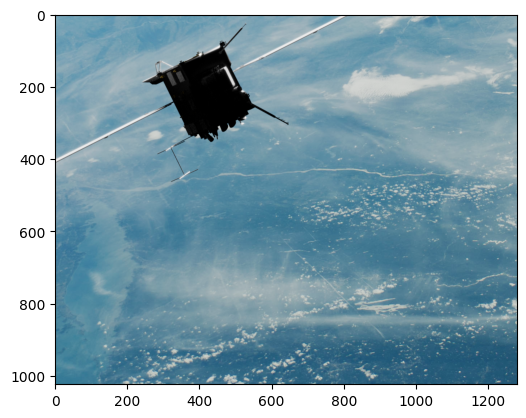

In [17]:
display_image_from_file('04e3b4e7bc79869d8eefc59f55914b6a')

<a id="model"></a>
## 🤖 | Model

In [18]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT", trainable_backbone_layers=0)
# Adjust the model for spacecraft recognition task.
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

num_classes = 2 # 2 classes are spacecraft or background
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace pre-trained head with new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [19]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
# Dummy dataset
dataset = SpacecraftDataset(train_labels, train_meta, transforms=transform)
data_loader = DataLoader(
    dataset,
    batch_size=5,
    shuffle=True,
    collate_fn=collate_fn
)

In [21]:
# Test a forward pass
images, targets = next(iter(data_loader))
images = list(images)
targets = list(targets)
output = model(images, targets)
print(output)

{'loss_classifier': tensor(0.6834, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1226, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0363, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0019, grad_fn=<DivBackward0>)}


In [22]:
# For inference
images, targets = next(iter(data_loader))
images = list(images)
model.eval()
predictions = model(images)
print(predictions)

[{'boxes': tensor([[   0.0000,  187.7519,  572.4353,  565.9598],
        [  24.5479,  404.6991, 1063.5134,  990.2448],
        [ 469.9576,  419.8981,  552.0701,  524.6381],
        [ 781.2514,  259.1996, 1270.1593, 1024.0000],
        [ 221.2491,  202.6314,  599.9360,  684.3967],
        [ 956.8344,  186.6644, 1051.1373,  273.8256],
        [ 637.1592,   82.1980,  674.5422,  301.5302],
        [ 293.6619,   74.9082,  578.1163,  559.5366],
        [ 700.9258,  347.5720, 1248.0529,  688.3778],
        [ 409.0704,  591.2717,  471.8676,  681.7328],
        [ 246.1920,   82.9346,  327.7073,  138.7219],
        [ 957.7194,  172.7266, 1056.3881,  226.1788],
        [ 447.4341,   87.2137,  853.3201, 1024.0000],
        [ 103.6623,   62.7227,  136.9791,  109.4519],
        [ 151.2343,  174.9886,  683.1216,  491.4778],
        [ 295.7215,   89.4113,  475.4507,  285.7141],
        [ 628.2278,   40.8252,  691.0281,  365.8693],
        [ 103.0022,   82.9707,  399.6945,  716.3508],
        [ 255.381

<a id="loss-and-optimizer"></a>
## 🔍 | Loss & Optimizer

In [51]:
# optimizer
def get_predicted_bboxes(preds):
    bbox_list = []
    for pred in preds:
        if len(pred['boxes']) > 0:
            bbox_list.append(pred['boxes'][0])
        else:
            bbox_list.append(torch.Tensor([100,100,200,200]))
    return torch.stack(bbox_list).detach().numpy()

def get_target_bboxes(targets):
    return torch.stack([target['boxes'] for target in targets]).numpy().squeeze()

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params, lr=0.001)

<a id="training"></a>
## 🚂 | Training

In [24]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [25]:
def train_one_epoch(model, optimizer, data_loader, device, epoch,):
    model.train()
    header = f"Epoch: [{epoch}]"
    print(header + ' initiated:')

    for idx, data in enumerate(data_loader):
        print(f'  processing batch {idx}')
        images, targets = data
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        
        with torch.device(device=device):
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

        if not math.isfinite(loss):
            print(f"Loss is {loss}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(header + f" loss: {loss}")
    print('Model loss dict:', loss_dict, '\n')

In [26]:
model.to('cpu')
n_epochs = 2
for epoch in range(n_epochs):
    train_one_epoch(model, optimizer, data_loader=train_dl, device='cpu', epoch=epoch)

Epoch: [0] initiated:
  processing batch 0
  processing batch 1
Epoch: [0] loss: 0.9143220782279968
Model loss dict: {'loss_classifier': tensor(0.5905, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1373, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.1646, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0219, grad_fn=<DivBackward0>)} 

Epoch: [1] initiated:
  processing batch 0
  processing batch 1
Epoch: [1] loss: 0.5136513113975525
Model loss dict: {'loss_classifier': tensor(0.2705, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2125, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0205, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0102, grad_fn=<DivBackward0>)} 



In [76]:
def evaluate(model, data_loader):
    model.eval()
    jac_hist = []
    for idx, data in enumerate(data_loader):
        images, targets = data
        images = list(images)
        preds = model(images)
        print(preds)
        predicted_bboxes = get_predicted_bboxes(preds)
        target_bboxes = get_target_bboxes(targets)
        jac = jaccard_index(predicted_bboxes, target_bboxes)
        jac_hist.append(jac)
        print('Jaccard Index on validation set: ', jac)
        # Adjust to correct display summary statistics of batches
    jac_hist = np.concatenate([arr.flatten() for arr in jac_hist])
    return jac_hist, jac_hist.mean()

In [77]:
len(train_dl)

4

In [78]:
predictions[0]['boxes'][0].detach()

tensor([ 408.1051,  285.6831,  967.7833, 1024.0000])

In [79]:
evaluate(model, valid_dl)

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[450.1361, 466.3223, 472.4815, 500.9419]], grad_fn=<StackBackward0>), 'labels': tensor([1]), 'scores': tensor([0.1603], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[ 797.9844,  317.2827, 1273.5658, 1024.0000],
        [ 584.2324,  195.0224, 1158.1461, 1016.6890],
        [ 690.3409,    0.0000, 1270.0870,  829.4233]],
       grad_fn=<StackBackward0>), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.1221, 0.0784, 0.0577], grad_fn=<IndexBackward0>)}, {'boxes': tensor([[445.4135, 665.2454, 466.5427, 710.0216],
        [446.6737, 674.0156, 470.6210, 727.1368],
        [439.2687, 673.3818, 463.3675, 718.9005],
        [437.4874, 695.2810, 487.5327, 717.2941],
        [449.1582, 705.4383, 483.2675, 725.9417],
        [440.9892, 688.2380, 487.8240, 731.4759],
        [455.2242, 694.3893, 474.0525, 736.2875],
        [432.69

(array([0.00000000e+00, 9.10619470e-03, 6.68222781e-01, 3.52129757e-01,
        0.00000000e+00, 6.93907309e-02, 3.96799780e-02, 0.00000000e+00,
        0.00000000e+00, 6.54856996e-01, 3.53040019e-01, 0.00000000e+00,
        4.08478674e-01, 1.90738109e-01, 0.00000000e+00, 0.00000000e+00,
        6.15780104e-04, 1.81687245e-02, 2.52439694e-01, 1.20591421e-01]),
 0.15687294297171286)

## 📋 | Result

In [60]:
def show_image(img_idx=None, img=None, pred_bbox=None, target_bbox=None, ax=None):
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)

    if target_bbox is not None:
        xmin, ymin, xmax, ymax = target_bbox
        height = ymax - ymin
        width = xmax - xmin
        patch = Rectangle((xmin, ymin), width, height, fill=False, edgecolor='white', linewidth=2)
        ax.add_patch(patch)
        ax.text(xmin + width - 63, ymin + height - 30, 'Target', color='r', ha='center', va='center', fontsize=8, bbox=dict(facecolor='white', edgecolor='white', alpha=0.5))

    if pred_bbox is not None:
        xmin, ymin, xmax, ymax = pred_bbox
        height = ymax - ymin
        width = xmax - xmin
        patch = Rectangle((xmin, ymin), width, height, fill=False, edgecolor='blue', linewidth=2)
        ax.add_patch(patch)
        ax.text(xmin + width - 55, ymin + height - 30, 'Pred', color='white', ha='center', va='center', fontsize=8, bbox=dict(facecolor='blue', edgecolor='blue', alpha=0.5))
    
    if (pred_bbox is not None) and (target_bbox is not None):
       jac = jaccard_index(pred_bbox.reshape(1,4), target_bbox.reshape(1,4))
    else:
       jac = 'n/a' 

    title = f'Image: {img_idx}\nJaccard: {jac[0]:.4f}'
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [61]:
def display_images(images, targets, preds, cols=2):
    rows = (len(images) + cols - 1) // 2
    fig = plt.figure(figsize=(15, 5*rows))
    target_bboxes = get_target_bboxes(targets)
    predicted_bboxes = get_predicted_bboxes(preds)
    for idx, target in enumerate(targets):
        img_idx = target['image_id']
        target_bbox = target_bboxes[idx]
        pred_bbox = predicted_bboxes[idx]
        img = images[idx]
        ax = fig.add_subplot(rows, cols, idx + 1)
        show_image(img_idx, img, pred_bbox, target_bbox, ax)

In [62]:
images, targets = next(iter(valid_dl))
predictions = model(images)

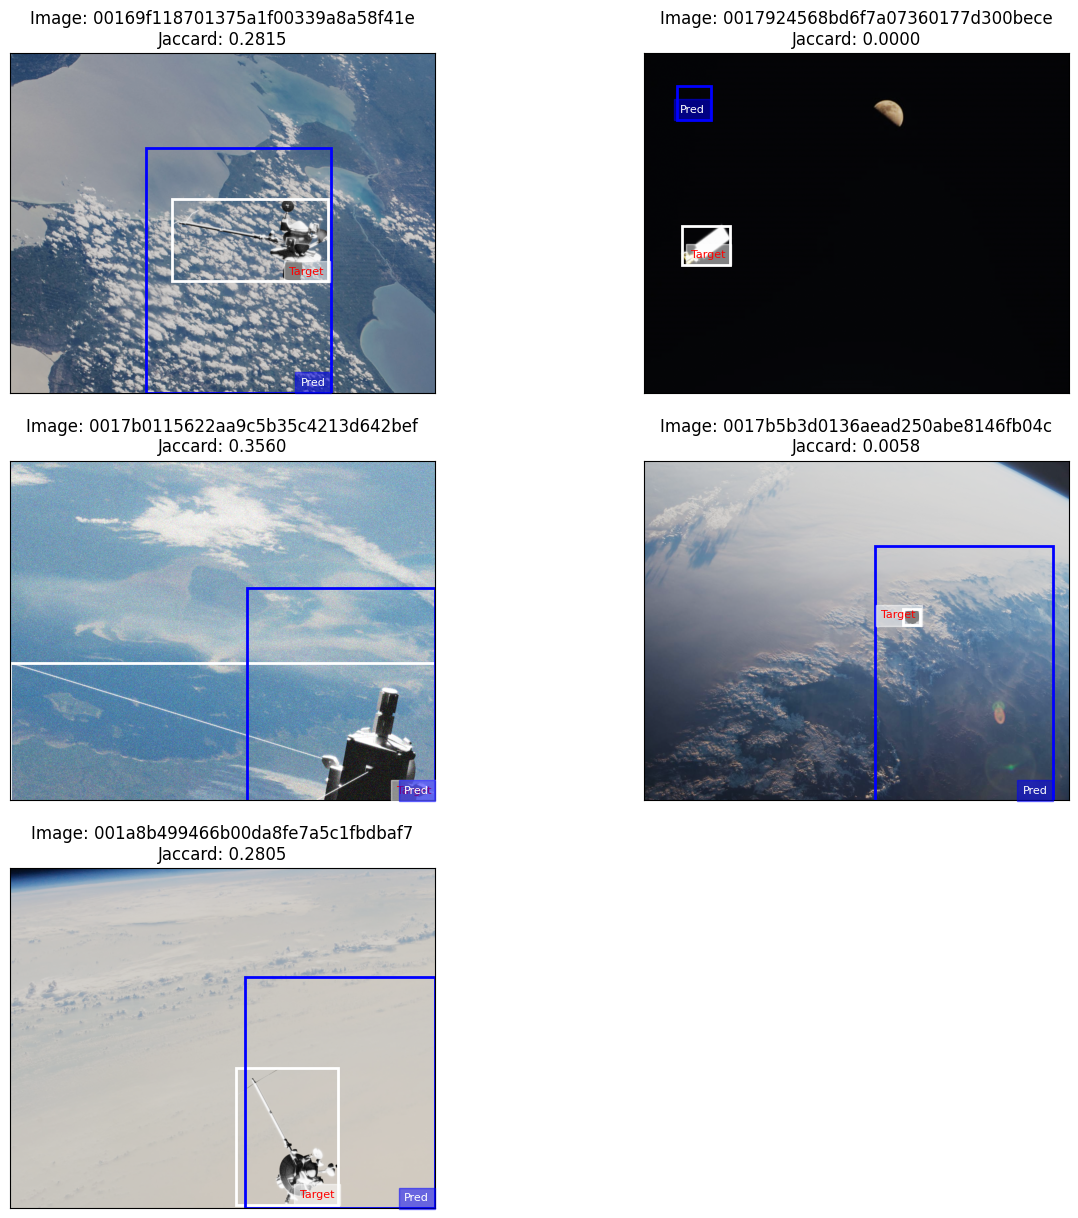

In [63]:
display_images(images, targets, predictions, cols=2)